In [1]:
import pandas as pd
from pathlib import Path


df = pd.read_csv(
    r"E:\Python Project\Spam-Email\Spam-Email-Detection-Classification\data\raw\spam.csv",
    encoding='latin-1')


In [2]:
df = df[['v1', 'v2']]
df.columns = ['label', 'text']

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape


(5572, 2)

In [4]:
df.isnull().sum()


label    0
text     0
dtype: int64

In [5]:
df['label'].value_counts()


label
ham     4825
spam     747
Name: count, dtype: int64

##
EDA

In [6]:
df['text_len'] = df['text'].apply(len)
df[['label', 'text_len']].groupby('label').mean()


,text_len
label,
ham,71.023627
spam,138.866131


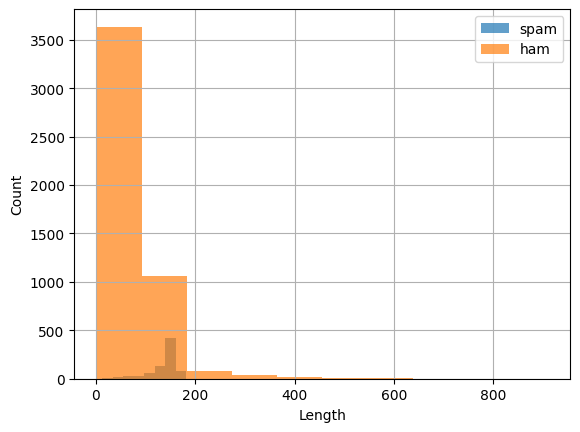

In [7]:
import matplotlib.pyplot as plt

df[df['label']=='spam']['text_len'].hist(alpha=0.7)
df[df['label']=='ham']['text_len'].hist(alpha=0.7)
plt.xlabel("Length")
plt.ylabel("Count")
plt.legend(["spam","ham"])
plt.show()


In [8]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [9]:
import sys
sys.executable


'e:\\Python Project\\Spam-Email\\spamenv\\Scripts\\python.exe'

In [10]:
import sys
from pathlib import Path

# مسیر پروژه اصلی
project_path = Path().resolve().parent  # اگه داخل notebooks هستی
# یا Path("E:/Python Project/Spam-Email/Spam-Email-Classification")
sys.path.append(str(project_path))
from src.preprocess import preprocess_text

df['clean_text'] = df['text'].apply(preprocess_text)
df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though


In [11]:
df['clean_text'].str.len().describe()

count    5572.000000
mean       50.470567
std        38.458141
min         0.000000
25%        22.000000
50%        38.000000
75%        74.000000
max       516.000000
Name: clean_text, dtype: float64

In [12]:
from src.features import create_tfidf_features

X, vectorizer = create_tfidf_features(df['clean_text'])
y = df['label']

X.shape


(5572, 3000)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
from src.train import train_model, evaluate_model

model = train_model(X_train, y_train)

acc, report = evaluate_model(model, X_test, y_test)

print("Accuracy:", acc)
print(report)


Accuracy: 0.967713004484305
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.98      0.77      0.86       149

    accuracy                           0.97      1115
   macro avg       0.97      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



e:\Python Project\Spam-Email\spamenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


In [15]:
from src.train import cross_validate_model

scores = cross_validate_model(X, y, cv=5)
scores, scores.mean()


(array([0.96950673, 0.95964126, 0.96140036, 0.95780969, 0.96229803]),
 np.float64(0.9621312122114787))

Hyperparameter Tuning

In [16]:
from src.train import tune_hyperparameters

best_model, best_params, best_score = tune_hyperparameters(X_train, y_train)

best_params, best_score


Fitting 5 folds for each of 10 candidates, totalling 50 fits


e:\Python Project\Spam-Email\spamenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


({'C': 10, 'penalty': 'l2', 'solver': 'liblinear'},
 np.float64(0.9542622914866337))

In [17]:
acc, report = evaluate_model(best_model, X_test, y_test)
print(acc)
print(report)


0.9829596412556054
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115

